In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [3]:
# ✅ 데이터 로딩
base_path = Path('C:/labs_python/Sesacfinalproject/output_image')
x_train_rgb = np.load(base_path / 'x_train_rgb_balanced.npy')
x_test_rgb = np.load(base_path / 'x_test_rgb_balanced.npy')
y_train = np.load(base_path / 'y_train_balanced.npy')
y_test = np.load(base_path / 'y_test_balanced.npy')

In [4]:
# ✅ 데이터 증강 (최적화)
datagen_rgb = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen_rgb.fit(x_train_rgb)

In [5]:
# ✅ 전이 학습 설정 (상위 레이어 Fine-Tuning 활성화)
base_model = MobileNetV2(input_shape=(112, 112, 3), include_top=False, weights='imagenet')
base_model.trainable = True

C:\Users\kenek\AppData\Local\Temp\ipykernel_20028\3363080828.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(112, 112, 3), include_top=False, weights='imagenet')


In [6]:
# ✅ 모델 구성 (Dropout과 BatchNormalization)
model_rgb = models.Sequential([
    base_model,
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid')
])

In [7]:
# ✅ 모델 컴파일 (학습률 증가)
model_rgb.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [8]:
# ✅ 조기 종료 콜백 (조기 종료 기준을 val_loss에서 val_accuracy로 변경)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/50


c:\labs_python\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.5339 - loss: 0.9086 - val_accuracy: 0.6739 - val_loss: 0.6120
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.5750 - loss: 0.8273 - val_accuracy: 0.6919 - val_loss: 0.5746
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.5827 - loss: 0.7735 - val_accuracy: 0.7261 - val_loss: 0.5535
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.6416 - loss: 0.7155 - val_accuracy: 0.7333 - val_loss: 0.5349
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.6612 - loss: 0.6731 - val_accuracy: 0.7387 - val_loss: 0.5179
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.6610 - loss: 0.6743 - val_accuracy: 0.7333 - val_loss: 0.5173
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.7050 - loss: 0.6129 - val_accuracy: 0.7423 - val_loss: 0.5048
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.6909 - loss: 0.6178 - val

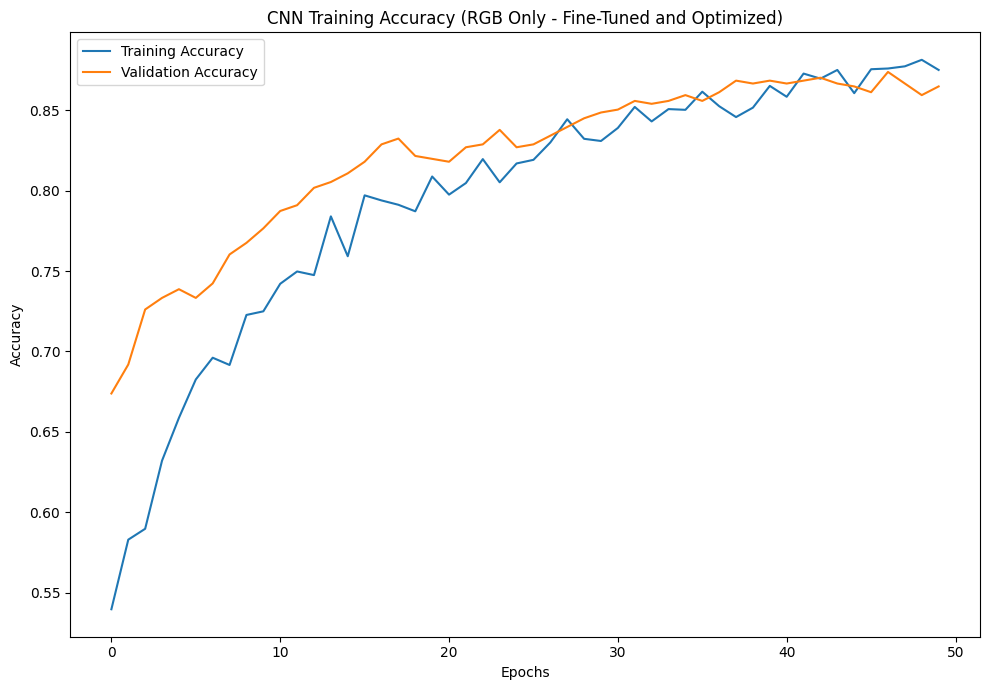

In [10]:
# ✅ 모델 훈련
history_rgb = model_rgb.fit(
    datagen_rgb.flow(x_train_rgb, y_train, batch_size=16),
    validation_data=(x_test_rgb, y_test),
    epochs=50,
    callbacks=[early_stopping]
)


# ✅ 학습 정확도 시각화
plt.figure(figsize=(10,7))
plt.plot(history_rgb.history['accuracy'], label='Training Accuracy')
plt.plot(history_rgb.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training Accuracy (RGB Only - Fine-Tuned and Optimized)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#model_rgb.save(base_path / 'trained_model_best0.h5')

C:\Users\kenek\AppData\Local\Temp\ipykernel_20028\3404200223.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(112, 112, 3), include_top=False, weights='imagenet')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


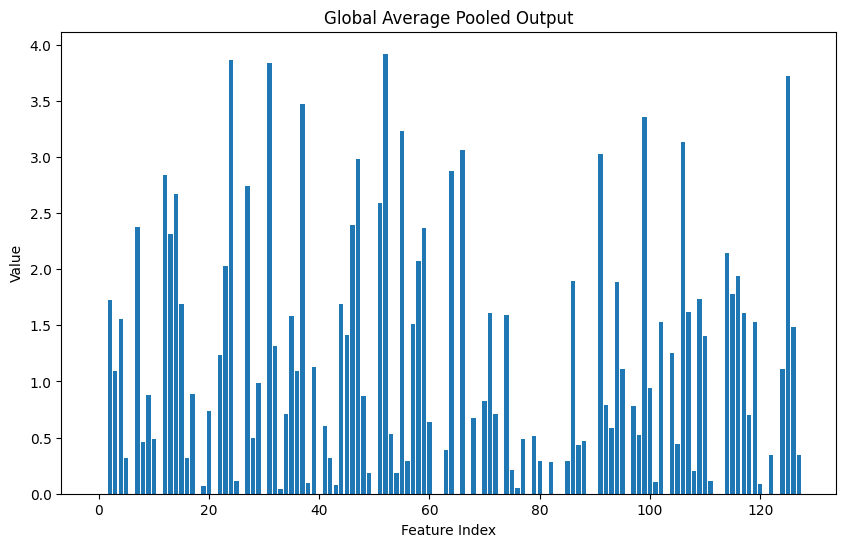

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt

# ✅ 모델 재구성 (명시적 입력 추가)
input_layer = Input(shape=(112, 112, 3))
base_model = MobileNetV2(input_shape=(112, 112, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# ✅ Dropout과 BatchNormalization 포함
x = base_model(input_layer)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.7)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# ✅ 모델 구성
model_rgb = models.Model(inputs=input_layer, outputs=output_layer)

# ✅ 모델에 데이터 한번 통과시켜 build 완료
model_rgb.compile(optimizer='adam', loss='binary_crossentropy')
model_rgb.predict(np.random.rand(1, 112, 112, 3))

# ✅ GlobalAveragePooling2D 레이어만을 추출하는 모델
intermediate_model = models.Model(inputs=model_rgb.input,
                                  outputs=model_rgb.get_layer('global_average_pooling2d').output)

# ✅ 예제 데이터로 예측 수행
sample_image = x_train_rgb[0:1]  # 첫 번째 이미지 사용
feature_map = intermediate_model.predict(sample_image)

# ✅ GlobalAveragePooling2D의 출력을 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_map[0])), feature_map[0])
plt.title('Global Average Pooled Output')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


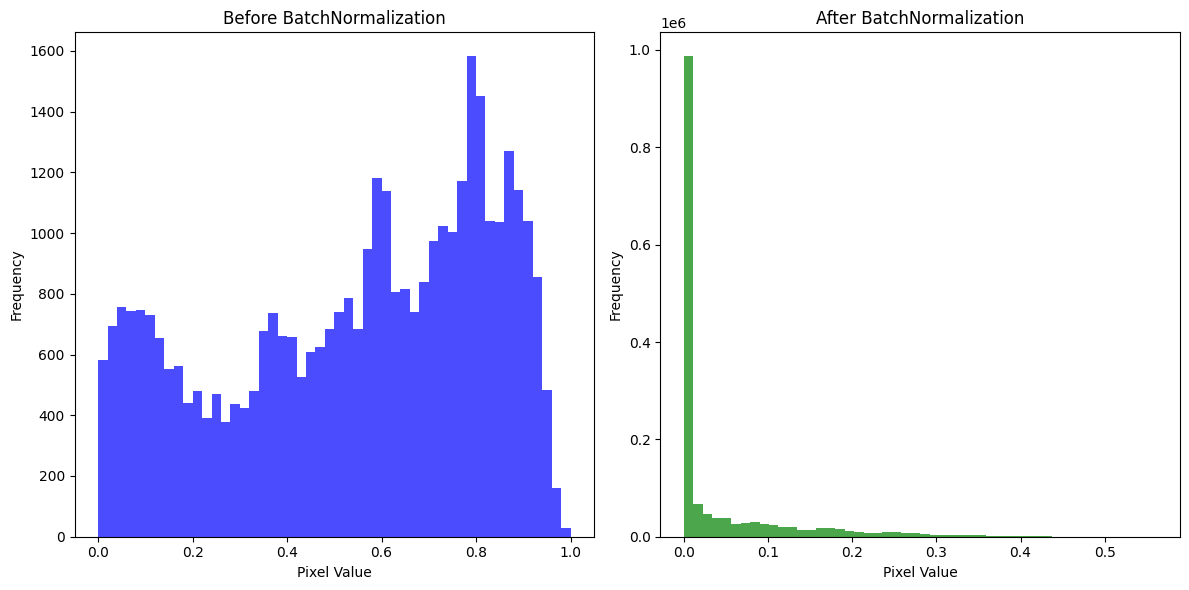

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, Input
import numpy as np

# ✅ 모델 재구성 (명시적 입력 추가)
input_layer = Input(shape=(112, 112, 3))
x = layers.Conv2D(128, (3,3), activation='relu')(input_layer)
x = layers.BatchNormalization(name='batch_normalization')(x)
x = layers.Dropout(0.7)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.7)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# ✅ 모델 컴파일
model_rgb = models.Model(inputs=input_layer, outputs=output_layer)
model_rgb.compile(optimizer='adam', loss='binary_crossentropy')

# ✅ 모델을 호출하여 입력 정의
sample_image = x_train_rgb[0:1]  
_ = model_rgb.predict(sample_image)  # 입력을 한 번 호출하여 정의

# ✅ BatchNormalization 이후의 출력을 추출하는 중간 모델 생성
intermediate_model_bn = models.Model(inputs=model_rgb.input, 
                                     outputs=model_rgb.get_layer('batch_normalization').output)

# ✅ BatchNormalization 전후 데이터 수집
original_output = sample_image.flatten()  # 원본 데이터
bn_output = intermediate_model_bn.predict(sample_image).flatten()  # BatchNormalization 적용 후

# ✅ 시각화: BatchNormalization 전/후 비교
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(original_output, bins=50, alpha=0.7, color='blue')
plt.title('Before BatchNormalization')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bn_output, bins=50, alpha=0.7, color='green')
plt.title('After BatchNormalization')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
